## this gets the data into csv format

In [7]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#this is commented out because it takes forever and I will just provide the filtered files. 
#however it is good to see how we did this

#open('filtered_data\q1_commit_messages_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q1_commit_messages.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q2_commit_dates_epoch_timestamp_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q2_commit_dates_epoch_timestamp.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q3_author_names_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q3_author_names.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q4_committer_names_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q4_committer_names.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q5_all_changed_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q5_all_changed_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q6_deleted_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q6_deleted_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q7_added_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q7_added_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q8_modified_files_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q8_modified_files.txt',encoding="utf8") if 'commit_log' in line)
#open('filtered_data\q10_commit_count_by_project_filtered.txt','w',encoding="utf8").writelines(line.replace('][',' ||| ').replace('] = ', ' ||| ').replace('commit_log[','') for line in open('raw_data\q10_commit_count_by_project.txt',encoding="utf8") if 'commit_log' in line)

## here we bring the filtered files in and merge the first set into one dataframe

In [11]:
messages = pd.read_csv('filtered_data/q1_commit_messages_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','message'])
timestamps = pd.read_csv('filtered_data/q2_commit_dates_epoch_timestamp_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','timestamp'])
authors = pd.read_csv('filtered_data/q3_author_names_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','author_name','commit_id'])
committers = pd.read_csv('filtered_data/q4_committer_names_filtered.txt', usecols=[0,1,2], sep='\|\|\|', names=['project_id','commit_id','committer_name'])

In [13]:
#merge all the message related files together
merge1 = pd.merge(messages,timestamps, on=['project_id','commit_id'])
merge2 = pd.merge(merge1, authors, on=['project_id','commit_id'])
merged_data = pd.merge(merge2,committers, on=['project_id','commit_id'])

In [15]:
#drop any rows that dont have a message because we dont need them
merged_data.dropna(subset=['message'], inplace=True)

In [17]:
#spit out all the messages to a file alone for processing by sentistrength
merged_data.message.to_csv('sentistrength_run/messages_only.csv', header=False, index=False)

## here, we manually run the sentistrength tool on the messages_only file, which produces the messages_only_results file which we can then merge with the main dataframe

In [19]:
#bring the strengths data in from the sentistrength results file
strengths = pd.read_csv('sentistrength_run/messages_only_results.txt', usecols=[1,2], sep='\t', dtype=str, names=['positive_strength','negative_strength'])

In [21]:
#merge the strengths with the main dataframe
merged_data.reset_index(drop=True, inplace=True)
commit_messages_final = pd.concat([merged_data,strengths],axis=1)

In [23]:
#convert the timestamp to date and add a day of week field
commit_messages_final["timestamp"] = commit_messages_final["timestamp"].astype(str)
commit_messages_final["timestamp"] = commit_messages_final["timestamp"].str[:10]
commit_messages_final['timestamp'] = pd.to_datetime(commit_messages_final['timestamp'],unit='s',errors='coerce')
commit_messages_final['day_of_week'] = commit_messages_final['timestamp'].dt.weekday_name

## done with commit messages, moving on to changed files

In [25]:
#Bring in all the file related stuff
all_changes = pd.read_csv('filtered_data/q5_all_changed_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
deletes = pd.read_csv('filtered_data/q6_deleted_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
adds = pd.read_csv('filtered_data/q7_added_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])
modifies = pd.read_csv('filtered_data/q8_modified_files_filtered.txt', usecols=[0,1], sep='\|\|\|', names=['commit_id','filepath'])

In [27]:
#tag the deletes
merge_deletes = pd.merge(all_changes, deletes, on=['commit_id','filepath'], how='left', indicator='modif')
merge_deletes['modif'] = np.where(merge_deletes.modif == 'both', 'Delete', '')

In [29]:
#tag the adds
merge_adds = pd.merge(all_changes, adds, on=['commit_id','filepath'], how='left', indicator='modif')
merge_adds['modif'] = np.where(merge_adds.modif == 'both', 'Add', '')

In [31]:
#tag the modifies
merge_modifies = pd.merge(all_changes, modifies, on=['commit_id','filepath'], how='left', indicator='modif')
merge_modifies['modif'] = np.where(merge_modifies.modif == 'both', 'Modify', '')

In [33]:
#merge the deletes and adds tag frames together
temp_files_merge = pd.merge(merge_deletes, merge_adds, on=['commit_id','filepath'])

In [35]:
#squash down the columns in the delete/add frame so the tags are in the same column
temp_files_merge['modif'] = temp_files_merge['modif_x'].where(temp_files_merge['modif_x'] != '', temp_files_merge['modif_y'])
temp_files_merge = temp_files_merge.drop(['modif_x','modif_y'],axis=1)

In [37]:
#merge the delete/add frame and the modify frame together
temp_files_merge2 = pd.merge(temp_files_merge, merge_modifies, on=['commit_id','filepath'])

In [39]:
#squash down the columns in the final frame so the all tags are in the same column
temp_files_merge2['modification'] = temp_files_merge2['modif_x'].where(temp_files_merge2['modif_x'] != '', temp_files_merge2['modif_y'])
files_changed_final = temp_files_merge2.drop(['modif_x','modif_y'],axis=1)

##  here are the final pandas dataframes:

In [41]:
commit_messages_final.head()

,project_id,commit_id,message,timestamp,author_name,committer_name,positive_strength,negative_strength,day_of_week,final_sentiment
0,10000244,0515c7d89f97bf7f1e488ac39dcc8fe1ee79f605,photo in progress,2013-05-11 15:52:20,syhw,syhw,1,-1,Saturday,0
1,10000244,07abeaf9bd85eb77f0774607161a7ccb3ed8dff3,stashing,2013-05-12 09:29:50,syhw,syhw,1,-1,Sunday,0
2,10000244,11f46d585bfc263e11b0556566559e6513cca0e4,R,2013-05-12 12:10:17,syhw,syhw,1,-1,Sunday,0
3,10000244,25ffeb626cd9146c483c6144b8208b5bd6cf26c4,"merged photo (working) with master, see TODOs...",2013-05-12 07:18:18,syhw,syhw,1,-1,Sunday,0
4,10000244,33ac9b6d9da4234c93ae3d9e0d7b0f41edb99d8a,Request task,2013-05-12 10:01:57,syhw,syhw,1,-1,Sunday,0


In [43]:
files_changed_final.head()

,commit_id,filepath,modification
0,000e3673387b662e32f1037eeaea2aa29b630448,Sources/Internal/Platform/TemplateMacOS/MainW...,Modify
1,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete
2,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete
3,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete
4,000e3673387b662e32f1037eeaea2aa29b630448,Tools/ResourceEditor/Classes/Qt/Tools/LodCorr...,Delete


# Analysis

### RQ1

In [94]:
#compute final sentiment value from sum of positive and negative
commit_messages_final['final_sentiment'] = pd.to_numeric(commit_messages_final['positive_strength']) + pd.to_numeric(commit_messages_final['negative_strength'])

In [47]:
#count the number of commits for each sentiment level
commits_by_sentiment = commit_messages_final.groupby(['final_sentiment']).count().reset_index()
commits_by_sentiment = commits_by_sentiment[['final_sentiment','project_id']]
commits_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)

In [92]:
#bin the commits by positive, negative, and neutral sentiment
commits_by_sentiment['percent_of_total'] = commits_by_sentiment['count'].divide(len(commit_messages_final)).multiply(100)
commits_by_sentiment['bin'] = pd.cut(commits_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
commits_by_sentiment

,final_sentiment,count,percent_of_total,bin
0,-4,47,0.002086,negative
1,-3,1819,0.080736,negative
2,-2,31340,1.391018,negative
3,-1,262278,11.641144,negative
4,0,1821462,80.845139,neutral
5,1,125868,5.586620,positive
6,2,9911,0.439897,positive
7,3,295,0.013094,positive
8,4,6,0.000266,positive


In [93]:
#sum up the total percent of each bin
commits_by_sentiment_binned = commits_by_sentiment.groupby(['bin']).sum().reset_index()
commits_by_sentiment_binned = commits_by_sentiment_binned[['bin','count','percent_of_total']]
commits_by_sentiment_binned

,bin,count,percent_of_total
0,negative,295484,13.114984
1,neutral,1821462,80.845139
2,positive,136080,6.039877


In [51]:
commits_by_project = commit_messages_final.groupby(['project_id']).count().reset_index()

In [53]:
commits_by_project = commits_by_project[['project_id','commit_id']]
commits_by_project.rename(columns={'commit_id':'count'}, inplace=True)
commits_by_project.sort_values(['count'], inplace=True)

In [55]:
commits_by_project.to_csv('commits_by_project_sorted.csv', sep='\t', encoding='utf-8')

### manually obtained large, average and low groups by examining file

In [57]:
largelist = ['12496978','10613094','5153143','7785050','1968812']
avglist = ['2424377','5256179','365893','6719407','13010741']
lowlist = ['10453653','10530838','11416657','4067771','1571039']

In [59]:
large_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(largelist)]
avg_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(avglist)]
low_projects = commit_messages_final.loc[commit_messages_final['project_id'].isin(lowlist)]

In [95]:
#get bin percentages for large projects
large_by_sentiment = large_projects.groupby(['final_sentiment']).count().reset_index()
large_by_sentiment = large_by_sentiment[['final_sentiment','project_id']]
large_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
large_by_sentiment['percent_of_total'] = large_by_sentiment['count'].divide(len(large_projects)).multiply(100)
large_by_sentiment['bin'] = pd.cut(large_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
large_by_sentiment_binned = large_by_sentiment.groupby(['bin']).sum().reset_index()
large_by_sentiment_binned = large_by_sentiment_binned[['bin','count','percent_of_total']]
large_by_sentiment_binned

,bin,count,percent_of_total
0,negative,8568,15.728604
1,neutral,42061,77.212982
2,positive,3845,7.058413


In [105]:
#get bin percentages for average projects
avg_by_sentiment = avg_projects.groupby(['final_sentiment']).count().reset_index()
avg_by_sentiment = avg_by_sentiment[['final_sentiment','project_id']]
avg_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
avg_by_sentiment['percent_of_total'] = avg_by_sentiment['count'].divide(len(avg_projects)).multiply(100)
avg_by_sentiment['bin'] = pd.cut(avg_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
avg_by_sentiment_binned = avg_by_sentiment.groupby(['bin']).sum().reset_index()
avg_by_sentiment_binned = avg_by_sentiment_binned[['bin','count','percent_of_total']]
avg_by_sentiment_binned

,bin,count,percent_of_total
0,negative,3970,17.082616
1,neutral,17987,77.396730
2,positive,1283,5.520654


In [106]:
#get bin percentages for low projects
low_by_sentiment = low_projects.groupby(['final_sentiment']).count().reset_index()
low_by_sentiment = low_by_sentiment[['final_sentiment','project_id']]
low_by_sentiment.rename(columns={'project_id':'count'}, inplace=True)
low_by_sentiment['percent_of_total'] = low_by_sentiment['count'].divide(len(low_projects)).multiply(100)
low_by_sentiment['bin'] = pd.cut(low_by_sentiment['final_sentiment'], [-5, -1, 0, 4], labels=['negative', 'neutral', 'positive'])
low_by_sentiment_binned = low_by_sentiment.groupby(['bin']).sum().reset_index()
low_by_sentiment_binned = low_by_sentiment_binned[['bin','count','percent_of_total']]
low_by_sentiment_binned

,bin,count,percent_of_total
0,negative,606,9.724005
1,neutral,5306,85.141207
2,positive,320,5.134788


### RQ2

In [61]:
weekdays = commit_messages_final.groupby('day_of_week').mean().reset_index()

In [62]:
weekdays = weekdays[['day_of_week','final_sentiment']]

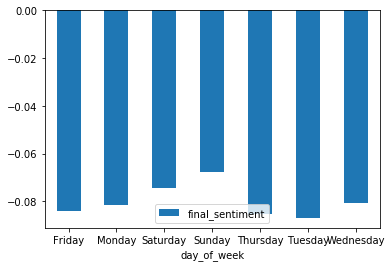

In [65]:
weekdays.plot.bar(x='day_of_week', y='final_sentiment', rot=0)
plt.show()

### RQ3
Is there a correlation between the number of changed files and developer sentiment? 

In [64]:
files_changed_count = files_changed_final.groupby('commit_id').count().reset_index()
files_changed_count = files_changed_count[['commit_id', 'modification']]
files_changed_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Data columns (total 2 columns):
commit_id       14956 non-null object
modification    14956 non-null int64
dtypes: int64(1), object(1)
memory usage: 233.8+ KB


In [66]:
df_sentiments_hashes = commit_messages_final[['commit_id','final_sentiment']]
df_sentiments_hashes.dropna(inplace=True)
df_sentiments_hashes.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2253026 entries, 0 to 2253025
Data columns (total 2 columns):
commit_id          object
final_sentiment    int64
dtypes: int64(1), object(1)
memory usage: 51.6+ MB


In [67]:
files_changed_count_merged = pd.merge(files_changed_count,df_sentiments_hashes,on='commit_id', how='left')

In [68]:
files_changed_count_merged.sort_values(['modification'], ascending=False).head()

,commit_id,modification,final_sentiment
4219,48c2b2f6590ecaeb22432332449be22cc3ef7257,7684,NaN
12541,d71c50d4458200a37ab2046f744be6da37845179,7494,NaN
5272,5a19809e53be3594bbf4a8c5dfa28f329c7d8ea6,7193,NaN
10137,adc4a2d8199f121fb23105e1241436f3cf9decf1,7160,NaN
6712,736e036389c7d0cee0578e5a7147501cd2fabe5a,6828,NaN


In [ ]:
#good for debugging
#commit_messages_final.loc[commit_messages_final['commit_id'].str.contains('000e3673387b662e32f1037eeaea2aa29b630448')]
